# IMPORTING LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import math
import os

from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import gc
import itertools
from tqdm import tqdm
from PIL import Image
from functools import partial
from collections import Counter

%matplotlib inline

# LOADING AND PREPROCESSING

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE, RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:10<00:00, 34.39it/s]


# CREATE LABEL

In [ ]:
#print label name
label =  {0:"benign", 1:"malignant"}
for i in label.keys() :
    print(i, label[i])

0 benign
1 malignant


In [ ]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# VISUALIZE DATA

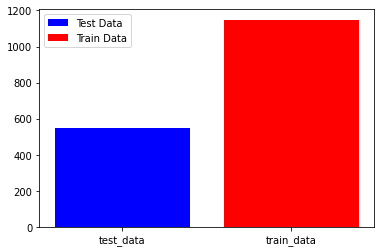

In [ ]:
#visualize data
fig, axis = plt.subplots()
axis.bar("test_data", 547, color='b', label='Test Data')
axis.bar("train_data", 1148 , color='r', label='Train Data')
legend = axis.legend()

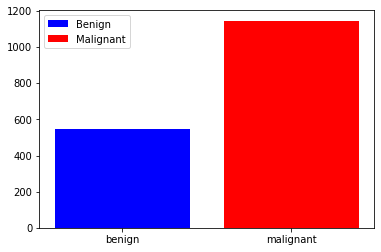

In [ ]:
#visualize data
fig, axis = plt.subplots()
axis.bar("benign", 547, color='b', label='Benign')
axis.bar("malignant", 1146 , color='r', label='Malignant')
legend = axis.legend()

In [ ]:
train_generator = ImageDataGenerator(
        zoom_range = 2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True,  # randomly flip images
)

BATCH_SIZE = 16

# TRAIN AND EVALUATION SPLIT

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size = 0.2, 
    random_state = 11
)

# DISPLAY IMAGES 

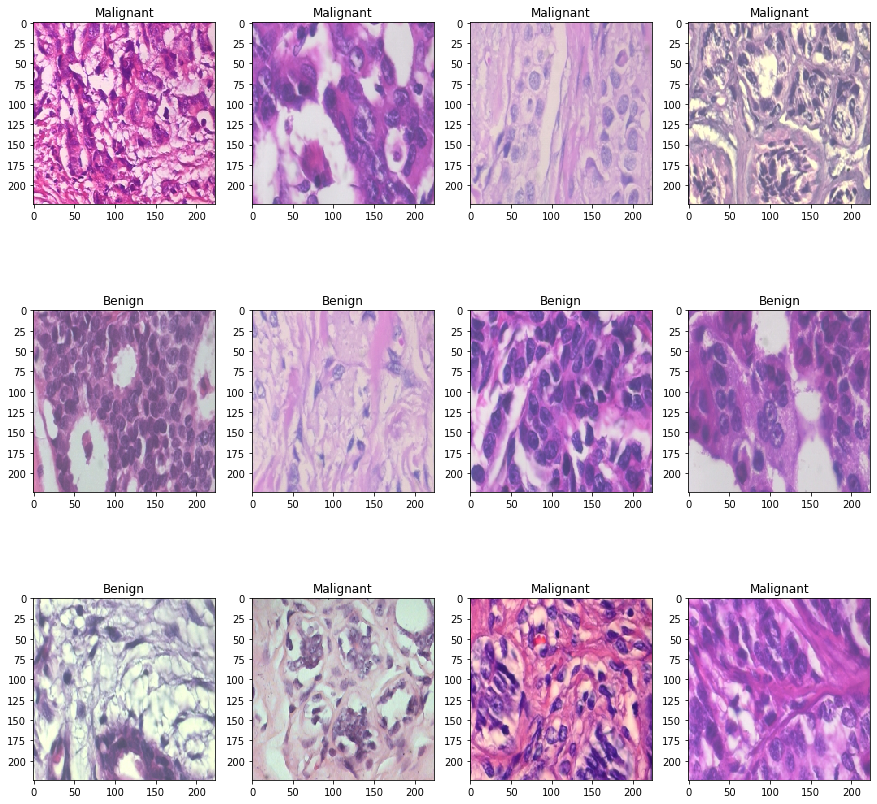

In [ ]:
# # Display first 15 images of moles, and how they are classified
w = 60
h = 40
fig = plt.figure(figsize = (15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# DATA GENERATOR 

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range =2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True,  # randomly flip images
    )

# BUILDING THE MODEL 1

In [ ]:
#build cnn
def build_model(backbone, lr = 1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(lr=lr),
        metrics = ['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

#DenseNet-201 is a convolutional neural network that is 201 layers deep.
resnet = DenseNet201(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

# TRAINING AND EVALUATION

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size = BATCH_SIZE),
    steps_per_epoch = x_train.shape[0] / BATCH_SIZE,
    epochs = 15,
    validation_data = (x_val, y_val),
    callbacks = [early_stop]
)

Epoch 1/15
57/57 [==============================] - 91s 907ms/step - loss: 0.7991 - accuracy: 0.5708 - val_loss: 0.6415 - val_accuracy: 0.7000
Epoch 2/15
57/57 [==============================] - 40s 691ms/step - loss: 0.6887 - accuracy: 0.6863 - val_loss: 0.6447 - val_accuracy: 0.6522
Epoch 3/15
57/57 [==============================] - 40s 692ms/step - loss: 0.5907 - accuracy: 0.7702 - val_loss: 0.5001 - val_accuracy: 0.7652
Epoch 4/15
57/57 [==============================] - 40s 692ms/step - loss: 0.5332 - accuracy: 0.7952 - val_loss: 0.3591 - val_accuracy: 0.8478
Epoch 5/15
57/57 [==============================] - 40s 693ms/step - loss: 0.4873 - accuracy: 0.8246 - val_loss: 0.3251 - val_accuracy: 0.8783
Epoch 6/15
57/57 [==============================] - 40s 693ms/step - loss: 0.5054 - accuracy: 0.8290 - val_loss: 0.2784 - val_accuracy: 0.9087
Epoch 7/15
57/57 [==============================] - 40s 694ms/step - loss: 0.4596 - accuracy: 0.8388 - val_loss: 0.2646 - val_accuracy: 0.8957

In [ ]:
#evaluate model
model.evaluate(x_val, y_val)

8/8 [==============================] - 2s 295ms/step - loss: 0.2187 - accuracy: 0.9174


[0.21872106194496155, 0.917391300201416]

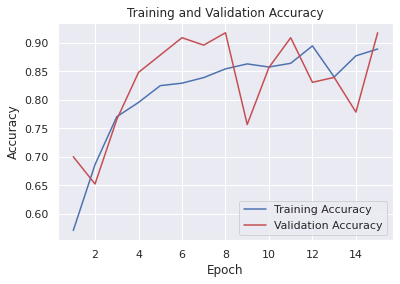

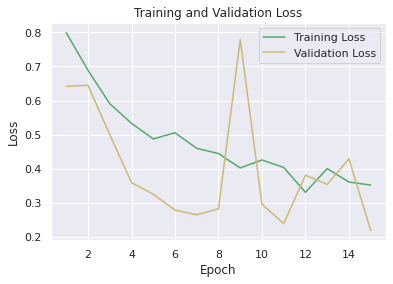

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, color = 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
 
#loss plot
plt.figure()
plt.plot(epochs, loss, color = 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'y', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# PREDICTION

In [ ]:
Y_pred = model.predict(X_test)
#Y_pred = np.argmax(Y_pred,axis=1)

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis = 1))

0.9173913043478261

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


# CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[134  42]
 [  7 362]]


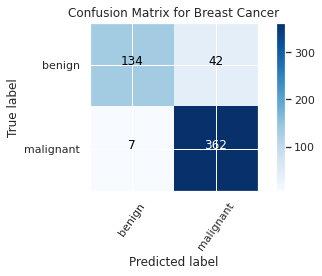

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[129  47]
 [  4 365]]


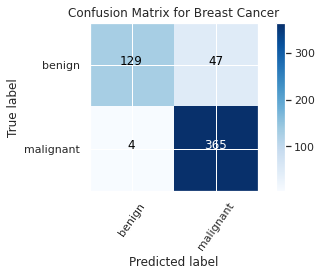

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

# CLASSIFICATION REPORT

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83       176
           1       0.89      0.99      0.93       369

    accuracy                           0.91       545
   macro avg       0.93      0.86      0.88       545
weighted avg       0.91      0.91      0.90       545



# ROC AND AUC

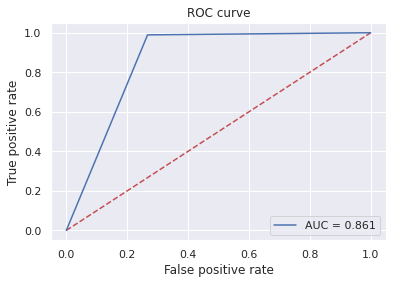

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

# DISPLAY SOME PREDICTIONS

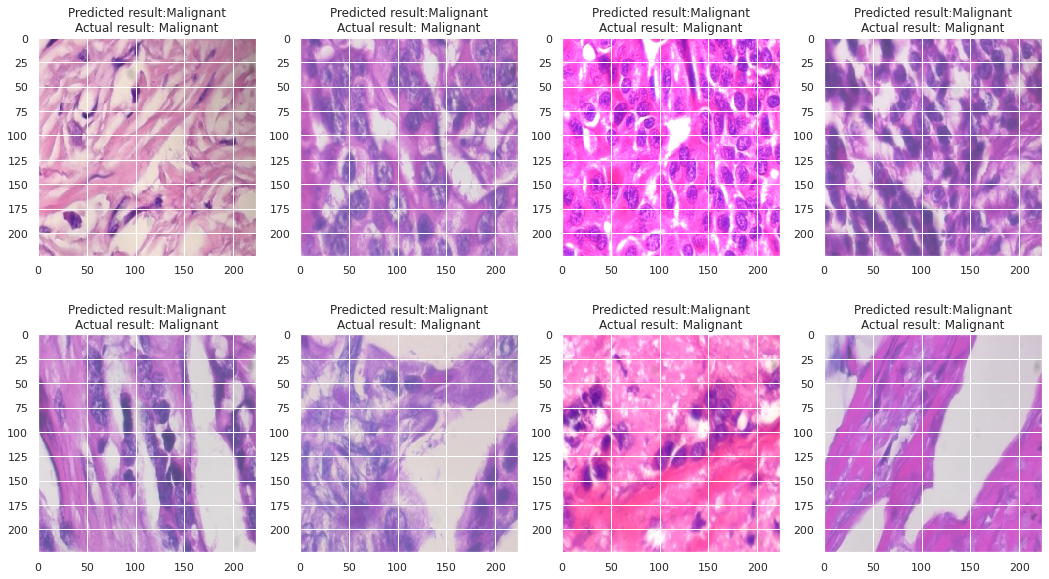

In [ ]:
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class) == 8):
        break

i = 0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class) == 8):
        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# TEST MODEL

[0]
benign


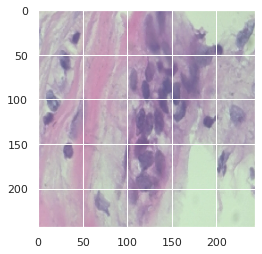

In [ ]:
#model 1 test 1
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


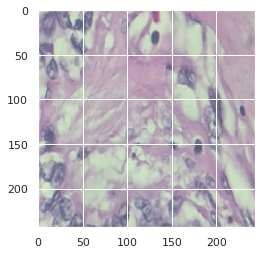

In [ ]:
#model 1 test 2
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_F-14-21998EF-400-011.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


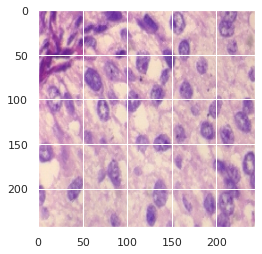

In [ ]:
#model 1 test 3
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/malignant/SOB_M_DC-14-11031-400-008.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


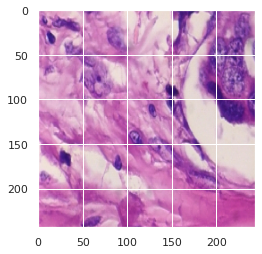

In [ ]:
#model 1 test 4
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/malignant/SOB_M_DC-14-12312-400-026.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)